In [1]:
from google.colab import files
uploaded = files.upload()

Saving AMZN_2006-01-01_to_2018-01-01.csv to AMZN_2006-01-01_to_2018-01-01.csv


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 26 21:58:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Importing Modules

In [4]:
# Basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Handling warnings
import warnings
warnings.filterwarnings('ignore')
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Model Building
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.optimizers import RMSprop
# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import time

In [5]:
# Setting seed
SEED = 1420
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Importing Data

In [6]:
data = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", parse_dates = ['Date'], index_col = 'Date')
del data['Name']
data = data.resample('B').ffill()
data

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127
2006-01-04,47.48,47.73,46.69,47.25,7440914
2006-01-05,47.16,48.20,47.11,47.65,5417258
2006-01-06,47.97,48.58,47.32,47.87,6154285
2006-01-09,46.55,47.10,46.40,47.08,8945056
...,...,...,...,...,...
2017-12-25,1172.08,1174.62,1167.83,1168.36,1585054
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208


# Preprocessing Functions

In [7]:
# Scale the data
def scale_data(data, index, scalertype):
    if scalertype == "minmax01": #minmax(0,1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
    elif scalertype == "minmax-11": # minmax(-1, 1)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(data)
    elif scalertype == "standard": #standardization
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame({'Open': scaled_data[:, 0], 'High': scaled_data[:, 1], 'Low': scaled_data[:, 2], 'Close': scaled_data[:, 3]}, index=index)
    return scaled_data


def sequence_data(data_normal, window_size, target_length):
    close = data_normal["Close"].values
    open = data_normal["Open"].values
    high = data_normal["High"].values
    low = data_normal["Low"].values
    X = []
    y = []
    pointer = 0
    data_length = len(close)
    while (pointer + window_size + target_length) <= data_length:
        x_close = close[pointer : pointer + window_size].reshape(-1, 1)
        x_open = open[pointer : pointer + window_size].reshape(-1, 1)
        x_high = high[pointer : pointer + window_size].reshape(-1, 1)
        x_low = low[pointer : pointer + window_size].reshape(-1, 1)
        x_ = np.append(x_close, x_open, axis=1)
        x_ = np.append(x_, x_high, axis=1)
        x_ = np.append(x_, x_low, axis=1)
        X.append(x_)
        y.append(close[pointer + window_size : pointer + window_size + target_length])
        pointer += 1
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y


def split_data(X, y, split_rate=0.2):
    split = int(len(X) * (1 - split_rate))
    X_train = X[:split, :]
    y_train = y[:split]
    X_test = X[split:, :]
    y_test = y[split:]
    return X_train, y_train, X_test, y_test

# Model Function

In [8]:
def rnn_model(X, y, learn_rate, dropout, summary = False):
    model = Sequential()
    model.add(SimpleRNN(units=X.shape[1], input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1], activation='tanh'))

    optimizer = RMSprop(learning_rate=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    if summary == True:
      model.summary()
    return model

# Run the RNN Model with Sensitivity Analysis

In [ ]:
window_sizes = [100, 150, 250]
dropouts = [0.0, 0.25, 0.4]
learn_rates = [0.1, 0.01, 0.001]
epochs = [500]
batch_sizes = [32]
scaling = ["minmax01"]

# window_sizes = [100]
# dropouts = [0.25, 0.5]
# learn_rates = [0.01]
# epochs = [100, 200, 500]
# batch_sizes = [32, 64, 128]
# scaling = ["minmax01", "minmax-11", "standard"]

# window_sizes = [100]
# dropouts = [0.25]
# learn_rates = [0.001]
# epochs = [500]
# batch_sizes = [32]
# scaling = ["minmax01"]

results_list = []


def best_model(data, window_sizes, learn_rates, dropouts, epochs, batch_size, scaling):
    #our best model variables
    best_model = None
    lowest_test_error = 2.0
    best_training_error =0.0
    best_learn_rate = 0.0
    best_dropout_rate = 0.0
    best_epoch = 0
    best_window_size = 0

    counter = 1

    for sc in scaling:
        normalized_data = scale_data(data, data.index, sc)

        for window_size in window_sizes:
            print("\nWindow size: {}".format(window_size))
            print('-'* 40)

            # Prepare our sequence data
            X, y = sequence_data(normalized_data, window_size, 1)
            X_train, y_train, X_test, y_test = split_data(X, y, split_rate=0.2)

            for rate in learn_rates:
                print("\n   Learning Rate: {}".format(rate))
                print('   *'* 30)
                for dropout in dropouts:
                    print("\n      Dropout Rate: {}".format(dropout))
                    print('      ='* 20)
                    for epoch in epochs:

                        print("\n         Epochs: {}".format(epoch))
                        print('         +'* 10)
                        for batch_size in batch_sizes:
                            with tf.device("/device:gpu:1"):
                                model = rnn_model(X_train, y_train, rate, dropout)
                                model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

                                # Print out training and testing errors
                                training_error = model.evaluate(X_train, y_train, verbose=0)
                                testing_error = model.evaluate(X_test, y_test, verbose=0)
                                msg = " > Scaling: {} Window size: {} Learn rate: {:.4f} Dropout: {:.2f} Epoch: {} Batch size: {} Training error: {:.4f} Testing error: {:.4f}"
                                msg = msg.format(sc, window_size, rate, dropout, epoch, batch_size, training_error, testing_error)
                                print(msg)

                                # Store the results in a list
                                result_dict = {
                                    "Scaling": sc,
                                    "Window_Size": window_size,
                                    "Learn_Rate": rate,
                                    "Dropout": dropout,
                                    "Epoch": epoch,
                                    "Batch_Size": batch_size,
                                    "Training_Error": training_error,
                                    "Testing_Error": testing_error
                                }
                                results_list.append(result_dict)

                                #check if test error
                                if lowest_test_error > testing_error:
                                    best_model = model
                                    lowest_test_error = testing_error
                                    best_learn_rate = rate
                                    best_dropout_rate = dropout
                                    best_epoch = epoch
                                    best_training_error = training_error
                                    best_window_size = window_size

                                #increase our print counter
                                counter += 1
    best_dict ={}
    best_dict["model"] = best_model
    best_dict["test_error"] =   "{0:.4f}".format(lowest_test_error)
    best_dict["learn_rate"] = best_learn_rate
    best_dict["dropout"] = best_dropout_rate
    best_dict["epoch"] = best_epoch
    best_dict["train_error"] =  "{0:.4f}".format(best_training_error)
    best_dict["window_size"] = best_window_size

    return best_dict, results_list

best_dict, results_list = best_model(data, window_sizes, learn_rates, dropouts, epochs, batch_sizes, scaling)
# Create a Pandas DataFrame from the results list
results_df = pd.DataFrame(results_list)
results_df.to_csv("rnn_results", index=False, encoding="latin1")


Window size: 100
----------------------------------------

   Learning Rate: 0.1
   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *

      Dropout Rate: 0.0
      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =

         Epochs: 500
         +         +         +         +         +         +         +         +         +         +


# Model Evaluation

In [ ]:
def model_eval(data, start_index, target_length, plot):
    normalized_data = scale_data(data, data.index, "minmax01")
    X, y = sequence_data(normalized_data, start_index, target_length)
    X_train, y_train, X_test, y_test = split_data(X, y, split_rate=0.2)
    with tf.device("/device:gpu:1"):
        model = rnn_model(X_train, y_train, 0.001, 0.25, summary = False)
        start_time = time.time()
        model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)
        end_time = time.time()
        # Calculate and print the running time
        running_time = end_time - start_time
        print(f"Running time: {running_time} seconds")
        XTrainPred = model.predict(X_train)
        XTestPred = model.predict(X_test)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    eval_start_index = start_index + target_length - 1
    data_index_subset = data.index[eval_start_index:]
    split_index = XTrainPred.shape[0]

    # Concatenate arrays XTrainPred and XTestPred row-wise
    result_array = np.concatenate((XTrainPred[:, -1], XTestPred[:, -1]), axis=0)
    result_array = scaler.inverse_transform(result_array.reshape((result_array.shape[0], 1)))
    # Create a DataFrame with the concatenated array and data_index_subset as index
    result_df = pd.DataFrame(result_array, index=data_index_subset, columns=['combined_column'])
    split_date = result_df.index[split_index]

    # Display the resulting DataFrame
    print(result_df.shape)

    if plot == True:
        plt.plot(result_df, color = 'b')
        plt.plot(data['Close'], color='g')
        plt.axvline(x=result_df.index[split_index - 1], color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Closing price of stock')
        plt.title("RNN Price prediction for Amazon")
        plt.legend(['Actual','Prediction', 'Train-Test Split Line'], loc='center left', bbox_to_anchor=(1, 0.5))

        sub_axes = plt.axes([0.2, 0.6, .5, .25])
        # plot the zoomed portion
        sub_axes.plot(result_df.loc[split_date:,], c = 'b')
        sub_axes.plot(data['Close'].loc[split_date:,], c = 'g')
        sub_axes.axvline(x=result_df.index[split_index - 1], color='red', linestyle='--')
        sub_axes.tick_params(axis='x', rotation=45)

        plt.show()
        plt.show()

    mae = mean_absolute_error(data['Close'].loc[split_date:,], result_df.loc[split_date:,])
    mse = mean_squared_error(data['Close'].loc[split_date:,], result_df.loc[split_date:,])
    rmse = np.sqrt(mse)
    r2 = r2_score(data['Close'].loc[split_date:,], result_df.loc[split_date:,])
    mape = mean_absolute_percentage_error(data['Close'].loc[split_date:,], result_df.loc[split_date:,])
    print("Results of sklearn.metrics:")
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    print("MAPE:",mape)

    return mae, mse, rmse, r2, mape

Running time: 1432.0291812419891 seconds
19/19 [==============================] - 0s 8ms/step
(3029, 1)


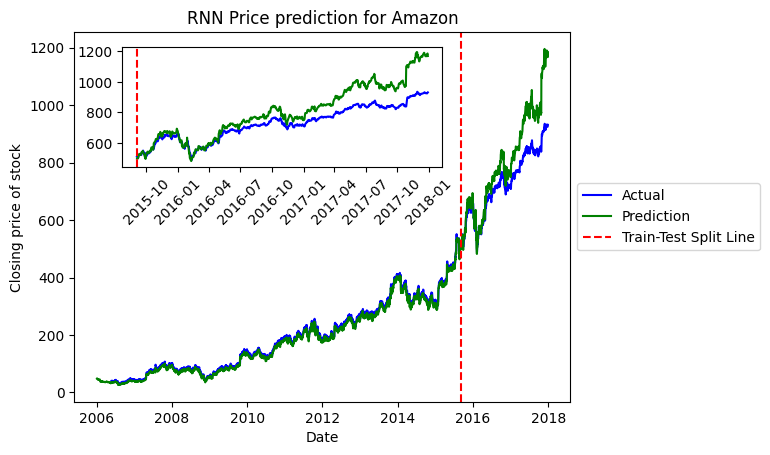

Results of sklearn.metrics:
MAE: 76.37982433558297
MSE: 10113.930456989165
RMSE: 100.5680389437378
R-Squared: 0.6725538234204792
MAPE: 0.08322381131143268


(76.37982433558297,
 10113.930456989165,
 100.5680389437378,
 0.6725538234204792,
 0.08322381131143268)

In [ ]:
model_eval(data, start_index=100, target_length=1, plot=True)

# Forecasting Power

In [ ]:
results = []
target_lengths = [1, 5, 10, 15, 20]
for target_length in target_lengths:
    mae, mse, rmse, r2, mape = model_eval(data, start_index=100, target_length = target_length, plot=False)
    results.append({
            'Target_Length': target_length,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R-Squared': r2,
            'MAPE': mape
        })
results_df = pd.DataFrame(results)

Running time: 1414.4063248634338 seconds
19/19 [==============================] - 0s 10ms/step
(3029, 1)
Results of sklearn.metrics:
MAE: 74.93142557578511
MSE: 9814.259387693433
RMSE: 99.06694397069808
R-Squared: 0.6822559017855301
MAPE: 0.08151544462721604
Running time: 1385.6021828651428 seconds
19/19 [==============================] - 0s 8ms/step
(3025, 1)
Results of sklearn.metrics:
MAE: 93.71023882199123
MSE: 12912.661077485536
RMSE: 113.6338905322067
R-Squared: 0.5805826870778996
MAPE: 0.10668481907723086
Running time: 1318.9645347595215 seconds
19/19 [==============================] - 0s 8ms/step
(3020, 1)
Results of sklearn.metrics:
MAE: 102.46251495967637
MSE: 14789.638475562942
RMSE: 121.61265754666717
R-Squared: 0.5180353462602771
MAPE: 0.11821694728968296
Running time: 1327.5832929611206 seconds
19/19 [==============================] - 0s 8ms/step
(3015, 1)
Results of sklearn.metrics:
MAE: 102.88573325187215
MSE: 15074.470797887301
RMSE: 122.77813648157111
R-Squared: 0.507

In [ ]:
results_df.to_csv("rnn", index=False, encoding="latin1")